## Face Generation Demo

This notebook demonstrates face generation process of the
method described in the paper "PixelCNN Models with Auxiliary Variables for Natural Image Generation": 
http://proceedings.mlr.press/v70/kolesnikov17a.html

In [1]:
import tensorflow as tf

# Load tensorflow utils and models
import utils

# Fix random seed for reproducable results
tf.set_random_seed(1)

# Load visualization libraries
import pylab
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

import numpy as np
import scipy.ndimage as nd
import cPickle
import os

## Set global parameters

In [2]:
# Computational mode. 'gpu' mode is recommended, 'cpu' mode can be quite slow.
mode = 'cpu'  # or 'cpu' is possible

# List of GPUs to use
gpu_list = [0]
num_gpus = len(gpu_list)

# Number of pyramid layers
num_pyramid_layers = 5

# Number of pyramid layers to generate (up to 5)
num_pyramid_layers_to_generate = 3

# Batch size
batch_size_per_gpu = 4
batch_size = batch_size_per_gpu * num_gpus

## Building the Pyramid PixelCNN Network

In [3]:
with tf.variable_scope('Resnet') as scope:
    
    # Create placeholder for images, which should be generated
    images = tf.placeholder(shape=[batch_size, None, None, 3], dtype=tf.float32)
    
    # Build multi-scale image pyramid
    images_pyramid = utils.get_pyramid(images, num_pyramid_layers - 1)
    
    pyramid_embeddings = []
    pyramid_predicted_images = []
    
    # Each iterations creates one Pyramid layer
    for layer_i in range(num_pyramid_layers):
        with tf.variable_scope('scale%d' % layer_i) as scope:
    
            images_current = images_pyramid[layer_i]
            images_prev = images_pyramid[layer_i + 1]

            # Technical step needed to properly create variables ####
            tf.GLOBAL['init'] = True
            _ = utils.PyramidPixelCNN(images_current, images_prev)
            tf.GLOBAL['init'] = False
            scope.reuse_variables()
            ##########################################################
            
            images_current_gpu_parts = tf.split(images_current, num_gpus, 0)
            images_prev_gpu_parts = (tf.split(images_prev, num_gpus, 0)
                                     if images_prev is not None
                                     else [None] * num_gpus)

            predicted_images = []
            embeddings = []

            for i, gpu_i in enumerate(gpu_list): 
                with tf.device('/gpu:%i' % gpu_i if mode == 'gpu' else '/cpu:0'):
                    
                    # Build tensorflow model for one super-resolution step
                    p, e = utils.PyramidPixelCNN(images_current_gpu_parts[i],
                                                 images_prev_gpu_parts[i])
                    predicted_images.append(p)
                    embeddings.append(e)

            pyramid_predicted_images.append(predicted_images)
            pyramid_embeddings.append(embeddings)
     
    
# Create Tensorflow expression to sample from the predicted pixel distributions 
variance = tf.placeholder(shape=[], dtype=tf.float32)
samples = [utils.sample_from_discretized_mix_logistic(tf.concat([pp for pp in p], 0), variance)
           for p in pyramid_predicted_images]

## This function implements sequential pixel-wise sampling for a given pyramid layer

In [32]:
def sample_from_model_at_layer(layer_i, image_prev_layer, sess, change_variance=0.0):
    
    # Infer resolution for the current layer
    resolution = 2 ** (int(np.log2(128)) - layer_i)
    
    if image_prev_layer is not None:
        x_gen = nd.zoom(image_prev_layer, (1, 2, 2, 1), order=0)
    else:
        x_gen = np.zeros((batch_size, resolution, resolution, 3))
        
    # Compute embedding of the image from the previous pyramid layer
    if pyramid_embeddings[layer_i][0] is not None:
        embedding_current = sess.run(pyramid_embeddings[layer_i],
                                     {images_pyramid[layer_i + 1]: image_prev_layer})
    else:
        embedding_current = None
    
    # Create figure to visualize sampling preocess
    f = plt.figure(figsize=(24, 8))
    
    # Run cycle over every pixel in the image
    for yi in range(resolution):
        for xi in range(resolution):
    
            FOV = 16
            if x_gen.shape[1] <= FOV:
                x_feed = x_gen
                y_sample = yi
                x_sample = xi
                embedding_feed = embedding_current
            else:
                cut_y, cut_x = 0, 0
                y_sample = yi
                x_sample = xi
                if yi >= FOV:
                    cut_y = yi - FOV + 1
                    y_sample = -1
                if xi >= FOV / 2:
                    cut_x = xi - FOV / 2
                    x_sample = FOV / 2
                x_feed = x_gen[:, cut_y:cut_y + FOV, cut_x:cut_x + FOV, :]
                embedding_feed = [e[:, cut_y:cut_y + FOV, cut_x:cut_x + FOV, :] for e in embedding_current]
                    
            # Sample new pixel
            feed = {images_pyramid[layer_i]: x_feed, variance: change_variance}
            if embedding_current is not None:
                [feed.update({pyramid_embeddings[layer_i][i]: r}) for i, r in enumerate(embedding_feed)]
            new_pixel = sess.run(samples[layer_i], feed)
            
            # Update current image
            x_gen[:, yi, xi, :] = new_pixel[:, y_sample, x_sample, :]
            
            # Add green pixel to simplify tracking of sampling process
            if (xi + 1) < resolution:
                 x_gen[:, yi, xi + 1, :] = np.array([0, 1.0, 0])[None]
            elif (yi + 1) < resolution:
                x_gen[:, yi + 1, 0, :] = np.array([0, 1.0, 0])[None]
             
            # Visualize current image ###################################
            
            # Set frequency of updates
            freq_update = {4: 3, 3: 20, 2: 70, 1: 70}
            
            if (yi * resolution + xi) % freq_update[layer_i] == 0:
                # Plot images
                for i in range(batch_size):
                    ax = f.add_subplot(1, batch_size, i + 1)
                    ax.imshow(utils.unprepro(x_gen[i]).astype('uint8'), interpolation='nearest')
                    ax.axis('off')
                display.display(plt.gcf())
                display.clear_output(wait=True)
                plt.clf()
                
            ###############################################################
      
    # Plot final samples
    for i in range(batch_size):
        ax = f.add_subplot(1, batch_size, i + 1)
        ax.imshow(utils.unprepro(x_gen[i]).astype('uint8'))
        ax.axis('off')

    return x_gen

In [33]:
# Retrieve pretrained model
if not os.path.exists('model.pickle'):
    import urllib
    model_file = urllib.URLopener()
    print('Downloading the pretrained model...')
    model_file.retrieve("https://pub.ist.ac.at/~akolesnikov/files/model.pickle", "model.pickle")
    print('Finished')
    
inits = utils.get_weight_initializer(dict(cPickle.load(open('model.pickle'))))

### variance_change is a crucial parameter, which controls variance of the sampled pixels
Negative values of this variable artifically reduce variance of the predicted pixel distribution and lead to better perceptual quality

In [34]:
variance_change = -10

# Create tensorflow session and run the computaitons

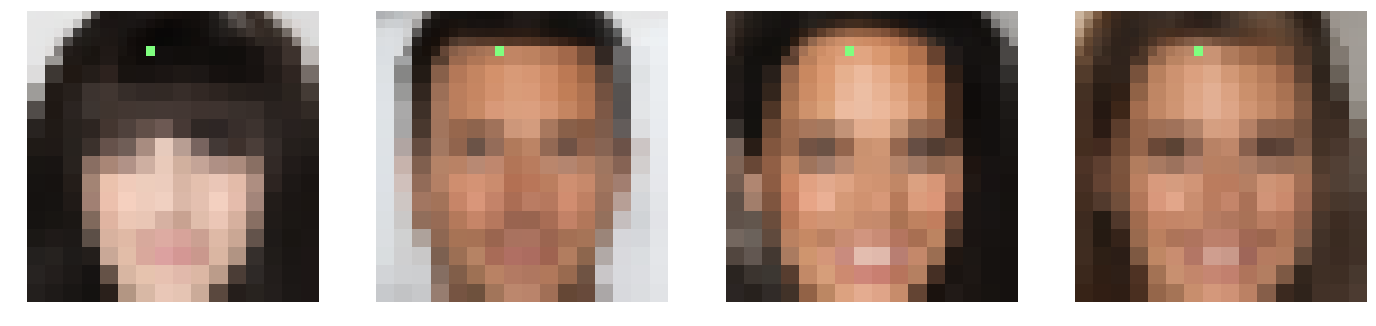

In [ ]:
with tf.Session() as sess:

    # Load pretrained weights
    sess.run(inits)

    # Produce samples
    image_list = [None]
    for layer_i in range(num_pyramid_layers_to_generate):
        sample = sample_from_model_at_layer(num_pyramid_layers - layer_i - 1,
                                            image_list[-1], sess, variance_change)
        image_list.append(sample)         
    image_list = image_list[1:]

### Try higher variance

In [ ]:
variance_change = 0.0

In [ ]:
with tf.Session() as sess:

    sess.run(inits)

    image_list = [None]

    for layer_i in range(num_pyramid_layers_to_generate):
        sample = sample_from_model_at_layer(num_pyramid_layers - layer_i - 1,
                                            image_list[-1], sess, variance_change)
        image_list.append(sample)
            
    image_list = image_list[1:]